In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
from statsmodels.graphics.mosaicplot import mosaic
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler

2024-06-28 15:17:44.700843: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-28 15:17:44.700958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-28 15:17:44.848375: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data=pd.read_csv('/kaggle/input/predicting-hiring-decisions-in-recruitment-data/recruitment_data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1500 non-null   int64  
 1   Gender               1500 non-null   int64  
 2   EducationLevel       1500 non-null   int64  
 3   ExperienceYears      1500 non-null   int64  
 4   PreviousCompanies    1500 non-null   int64  
 5   DistanceFromCompany  1500 non-null   float64
 6   InterviewScore       1500 non-null   int64  
 7   SkillScore           1500 non-null   int64  
 8   PersonalityScore     1500 non-null   int64  
 9   RecruitmentStrategy  1500 non-null   int64  
 10  HiringDecision       1500 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 129.0 KB


# EDA

In [4]:
newdata=data[:]
newdata['Gender']=data['Gender'].map({0:'Male',1:'Female'})
newdata['RecruitmentStrategy']=data['RecruitmentStrategy'].map({1:'Aggressive',2:' Moderate',3:'Conservative'})
def stack_bar(data,var1,var2,cmap,title):
    pd.crosstab(data[var1],data[var2]).plot(kind='bar',stacked=True,colormap=cmap)
    plt.title(title)
    plt.show()

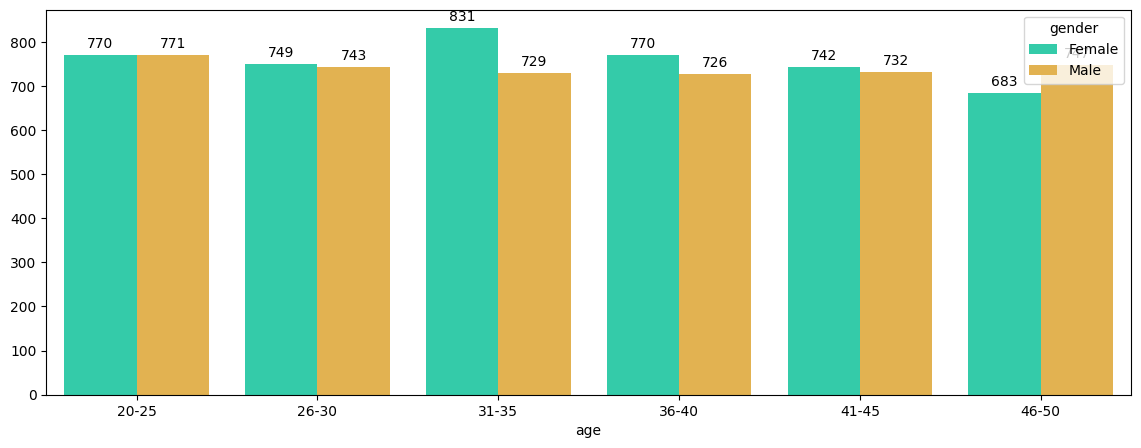

In [5]:
bins=[20,26,31,36,41,46,51]
categories=pd.cut(data['Age'],bins=bins,labels=['20-25','26-30','31-35','36-40','41-45','46-50'])
newdf1=pd.DataFrame(data=dict(gender=data['Gender'],age=categories))
newdf1['gender']=newdf1['gender'].replace({0:'Male',1:'Female'})
fig, ax = plt.subplots(figsize=(14, 5))
sb.barplot(data=newdf1,x='age',y=data.index,hue='gender',ax=ax,ci=None,palette='turbo')
for i in ax.patches:
    height = i.get_height()
    plt.annotate(f'{height:.0f}', 
                 xy=(i.get_x() + i.get_width() / 2., height), 
                 xytext=(0, 3), 
                 textcoords='offset points', 
                 ha='center', 
                 va='bottom', 
                 fontsize=10)


plt.show()

* Female at age between 31-35 have larger occurrence in dataset

Text(0.5, 1.0, 'Education Level')

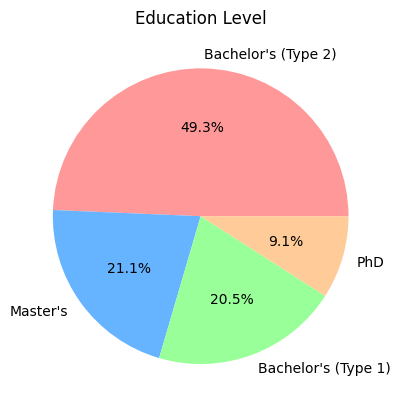

In [6]:
newdf2=data[['EducationLevel']]
newdf2['EducationLevel']=newdf2['EducationLevel'].map({1: "Bachelor's (Type 1)",
2: "Bachelor's (Type 2)",
3: "Master's",
4: "PhD"
})
newdf2['Age']=categories
EduLvl=newdf2['EducationLevel'].value_counts()
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
plt.pie(EduLvl,labels=EduLvl.index,autopct="%1.1f%%",colors=colors)
plt.title('Education Level')

* TYPE 2 BACHELORS SHOW MORE INTEREST IN INTERVIEWS(DATA)

Text(0.5, 1.0, 'Interview Scores')

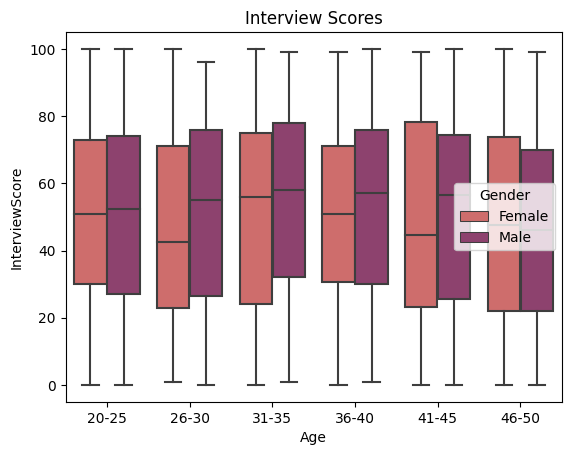

In [7]:
newdf3=data[['InterviewScore']]
newdf3['Age']=categories
newdf3['Gender']=newdf1['gender']
sb.boxplot(data=newdf3,x='Age',y='InterviewScore',hue='Gender',palette='flare')
plt.title('Interview Scores')

* Male have high mean of interview score when compared to female

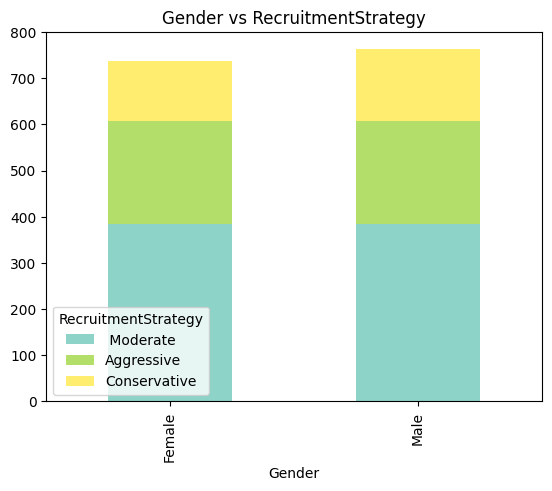

In [8]:
stack_bar(newdata,'Gender','RecruitmentStrategy','Set3','Gender vs RecruitmentStrategy')

Text(0.5, 1.0, 'YearsExperience')

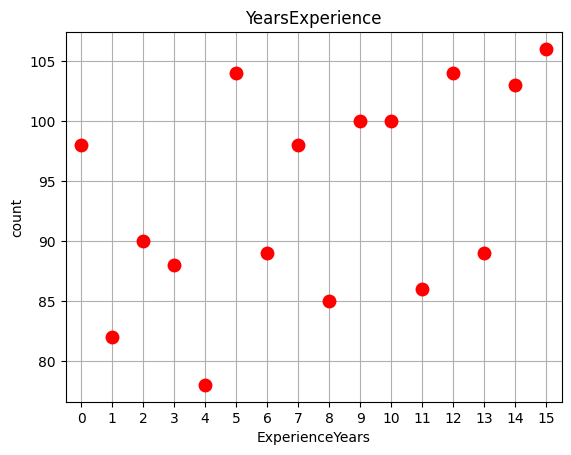

In [9]:
ExYears=data['ExperienceYears'].value_counts().sort_index()
sb.swarmplot(data=ExYears,x=ExYears.index,y=ExYears,color='red',size=10)
plt.grid()
plt.title('YearsExperience')

Text(0.5, 1.0, 'Using Regression Plot')

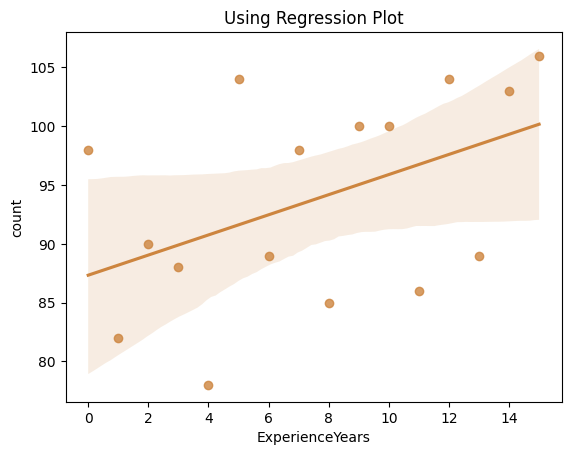

In [10]:
sb.regplot(data=ExYears,x=ExYears.index,y=ExYears,color='peru')
plt.title('Using Regression Plot')

* NOT SO MUCH LINEARLY CORRELATED

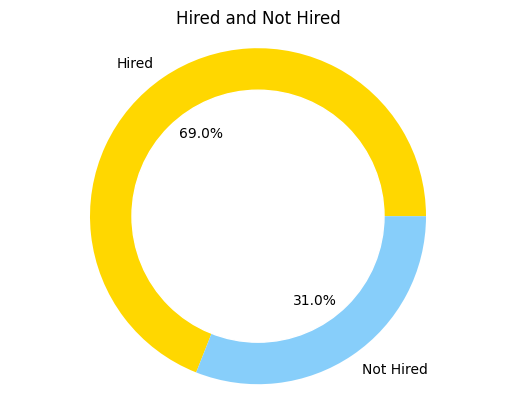

In [11]:
colors = ['gold','lightskyblue']
Class=data['HiringDecision'].value_counts()
labels=['Hired','Not Hired']
fig, ax = plt.subplots()

ax.pie(Class,labels=labels,colors=colors,autopct='%1.1f%%')
circle=plt.Circle((0,0),0.75,color='white')
ax.add_artist(circle)
plt.title('Hired and Not Hired')
ax.axis('equal')
plt.show()


* SO THE CLASS IMBALANCE PRESENT IN THE PREDITIVE COLUMN

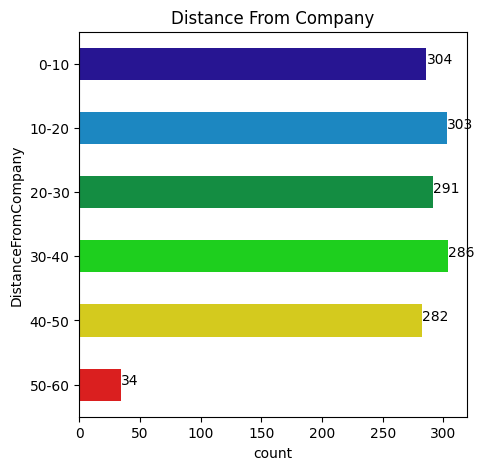

In [12]:
bins=[0,10,20,30,40,50,60]
DFC_value=pd.cut(x=data['DistanceFromCompany'],bins=bins,labels=['0-10','10-20','20-30','30-40','40-50','50-60']).value_counts()
fig,ax=plt.subplots(figsize=(5,5))
sb.barplot(x=DFC_value,y=DFC_value.index,ax=ax,width=0.5,palette='nipy_spectral')
j=0
for i in ax.patches:
    ax.text(i.get_width(),i.get_y()+i.get_height()/2,DFC_value[j])
    j+=1
ax.set_title('Distance From Company')
plt.show()

* THE DATA IS ABOUT MORE PEOPLES NEAR THE COMPANY

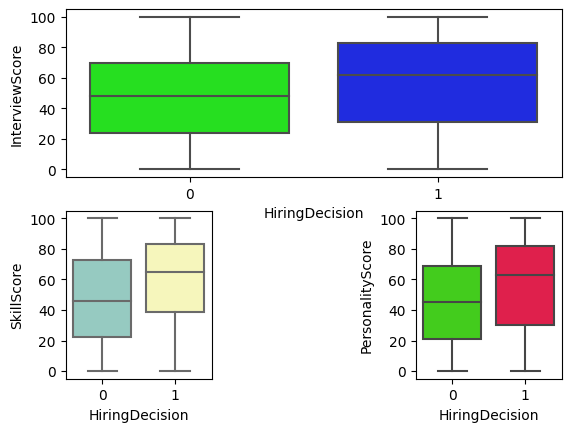

In [13]:
newdf4=data[['InterviewScore','SkillScore','PersonalityScore','HiringDecision']]
axes=plt.subplot_mosaic("""AAA
                           B.C""")
sb.boxplot(data=newdf4,x='HiringDecision',y='InterviewScore',ax=axes[1]['A'],palette='hsv')
sb.boxplot(data=newdf4,y='SkillScore',x='HiringDecision',ax=axes[1]['B'],palette='Set3')
sb.boxplot(data=newdf4,y='PersonalityScore',x='HiringDecision',ax=axes[1]['C'],palette='prism')
plt.show()

* Clearly We can see that the hired people has larger Scores

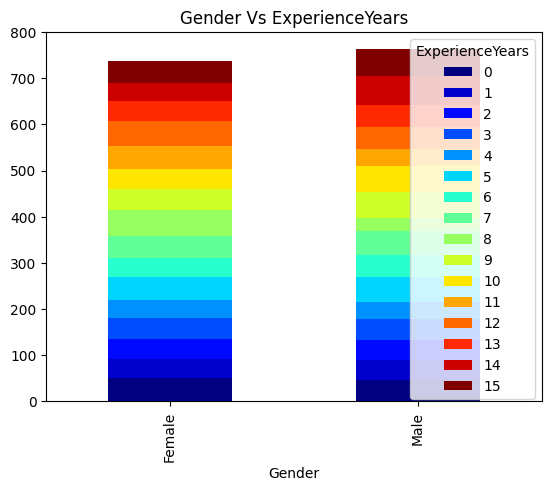

In [14]:
stack_bar(newdata,'Gender','ExperienceYears','jet','Gender Vs ExperienceYears')

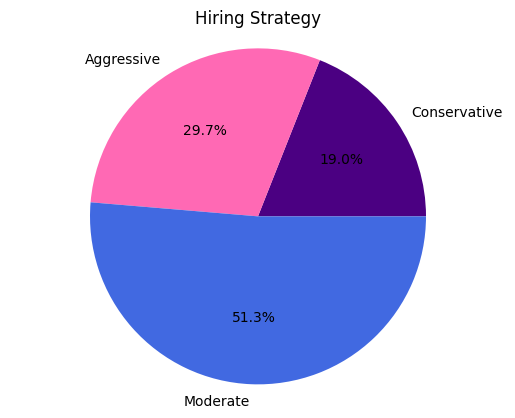

In [15]:
RS_Counts=data['RecruitmentStrategy'].value_counts().sort_values()
labels={1: 'Aggressive',
    2: 'Moderate',
    3: 'Conservative'}
colors=['indigo','hotpink','royalblue']
plt.pie(x=RS_Counts,labels = [labels[i] for i in RS_Counts.index],autopct='%1.1f%%',colors=colors)
plt.axis('equal')
plt.title('Hiring Strategy')
plt.show()

* MODERATE HIRING IS HAPPENING MORE OFTEN ACCORDING TO DATA

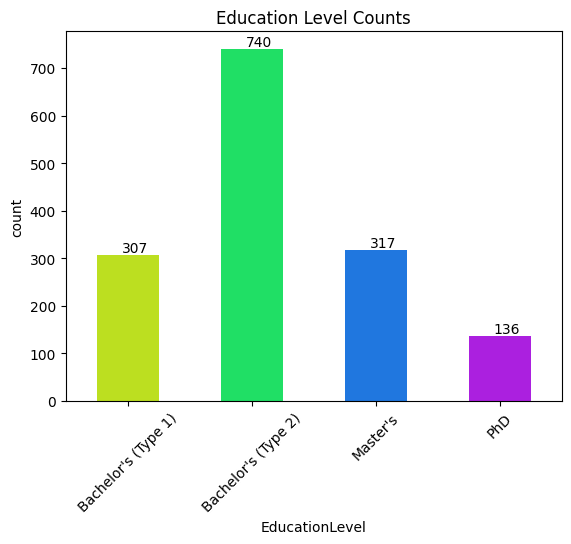

In [16]:
gen_val=data['EducationLevel'].value_counts()
fig,ax=plt.subplots()
sb.barplot(width=0.5,y=gen_val,x=gen_val.index,palette='hsv',ax=ax)
for i in ax.patches:
    height = i.get_height()
    plt.annotate(f'{height:.0f}', 
                 xy=(i.get_x()+0.2, height),va='bottom')
edu_dict={1: "Bachelor's (Type 1)",
2: "Bachelor's (Type 2)",
3: "Master's",
4: "PhD"
}
plt.xticks(ticks=[0,1,2,3],labels=list(edu_dict.values()),rotation=45)
plt.title('Education Level Counts')
plt.show()

* THE ABOVE PLOT SHOWS THE EXACT COUNT OF EDUDATION LEVELS OF PEOPLES

Text(0.5, 1.0, 'Finding Scores relationship with target variable')

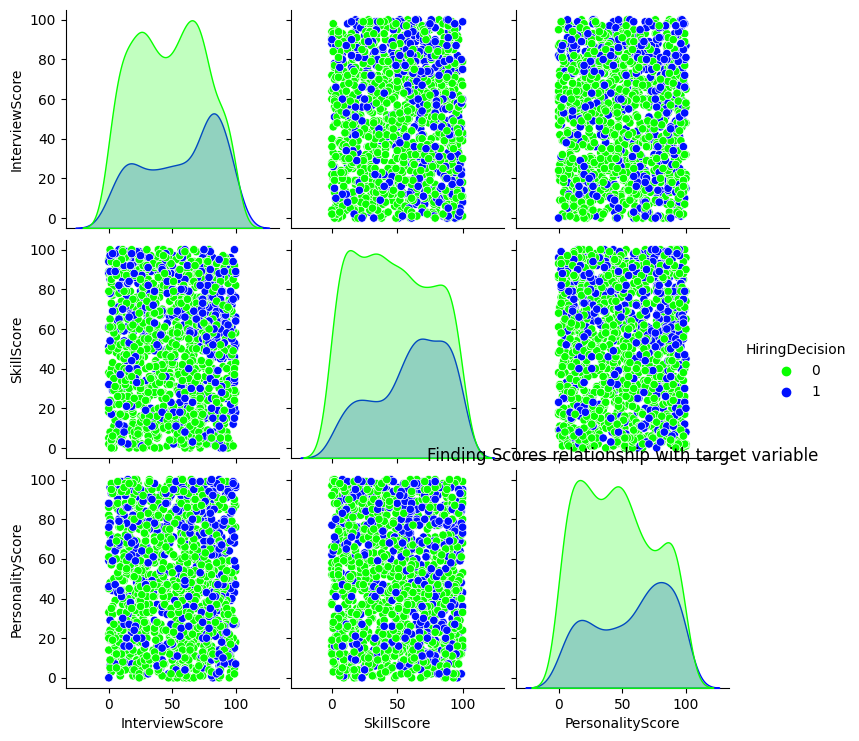

In [17]:
sb.pairplot(newdf4,hue='HiringDecision',palette='hsv')
plt.title("Finding Scores relationship with target variable")

* We are unable to find any relationships with scores and hiring decision

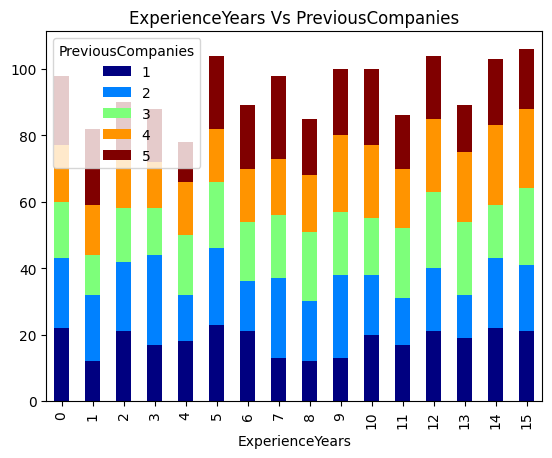

In [18]:
stack_bar(newdata,'ExperienceYears','PreviousCompanies','jet','ExperienceYears Vs PreviousCompanies')

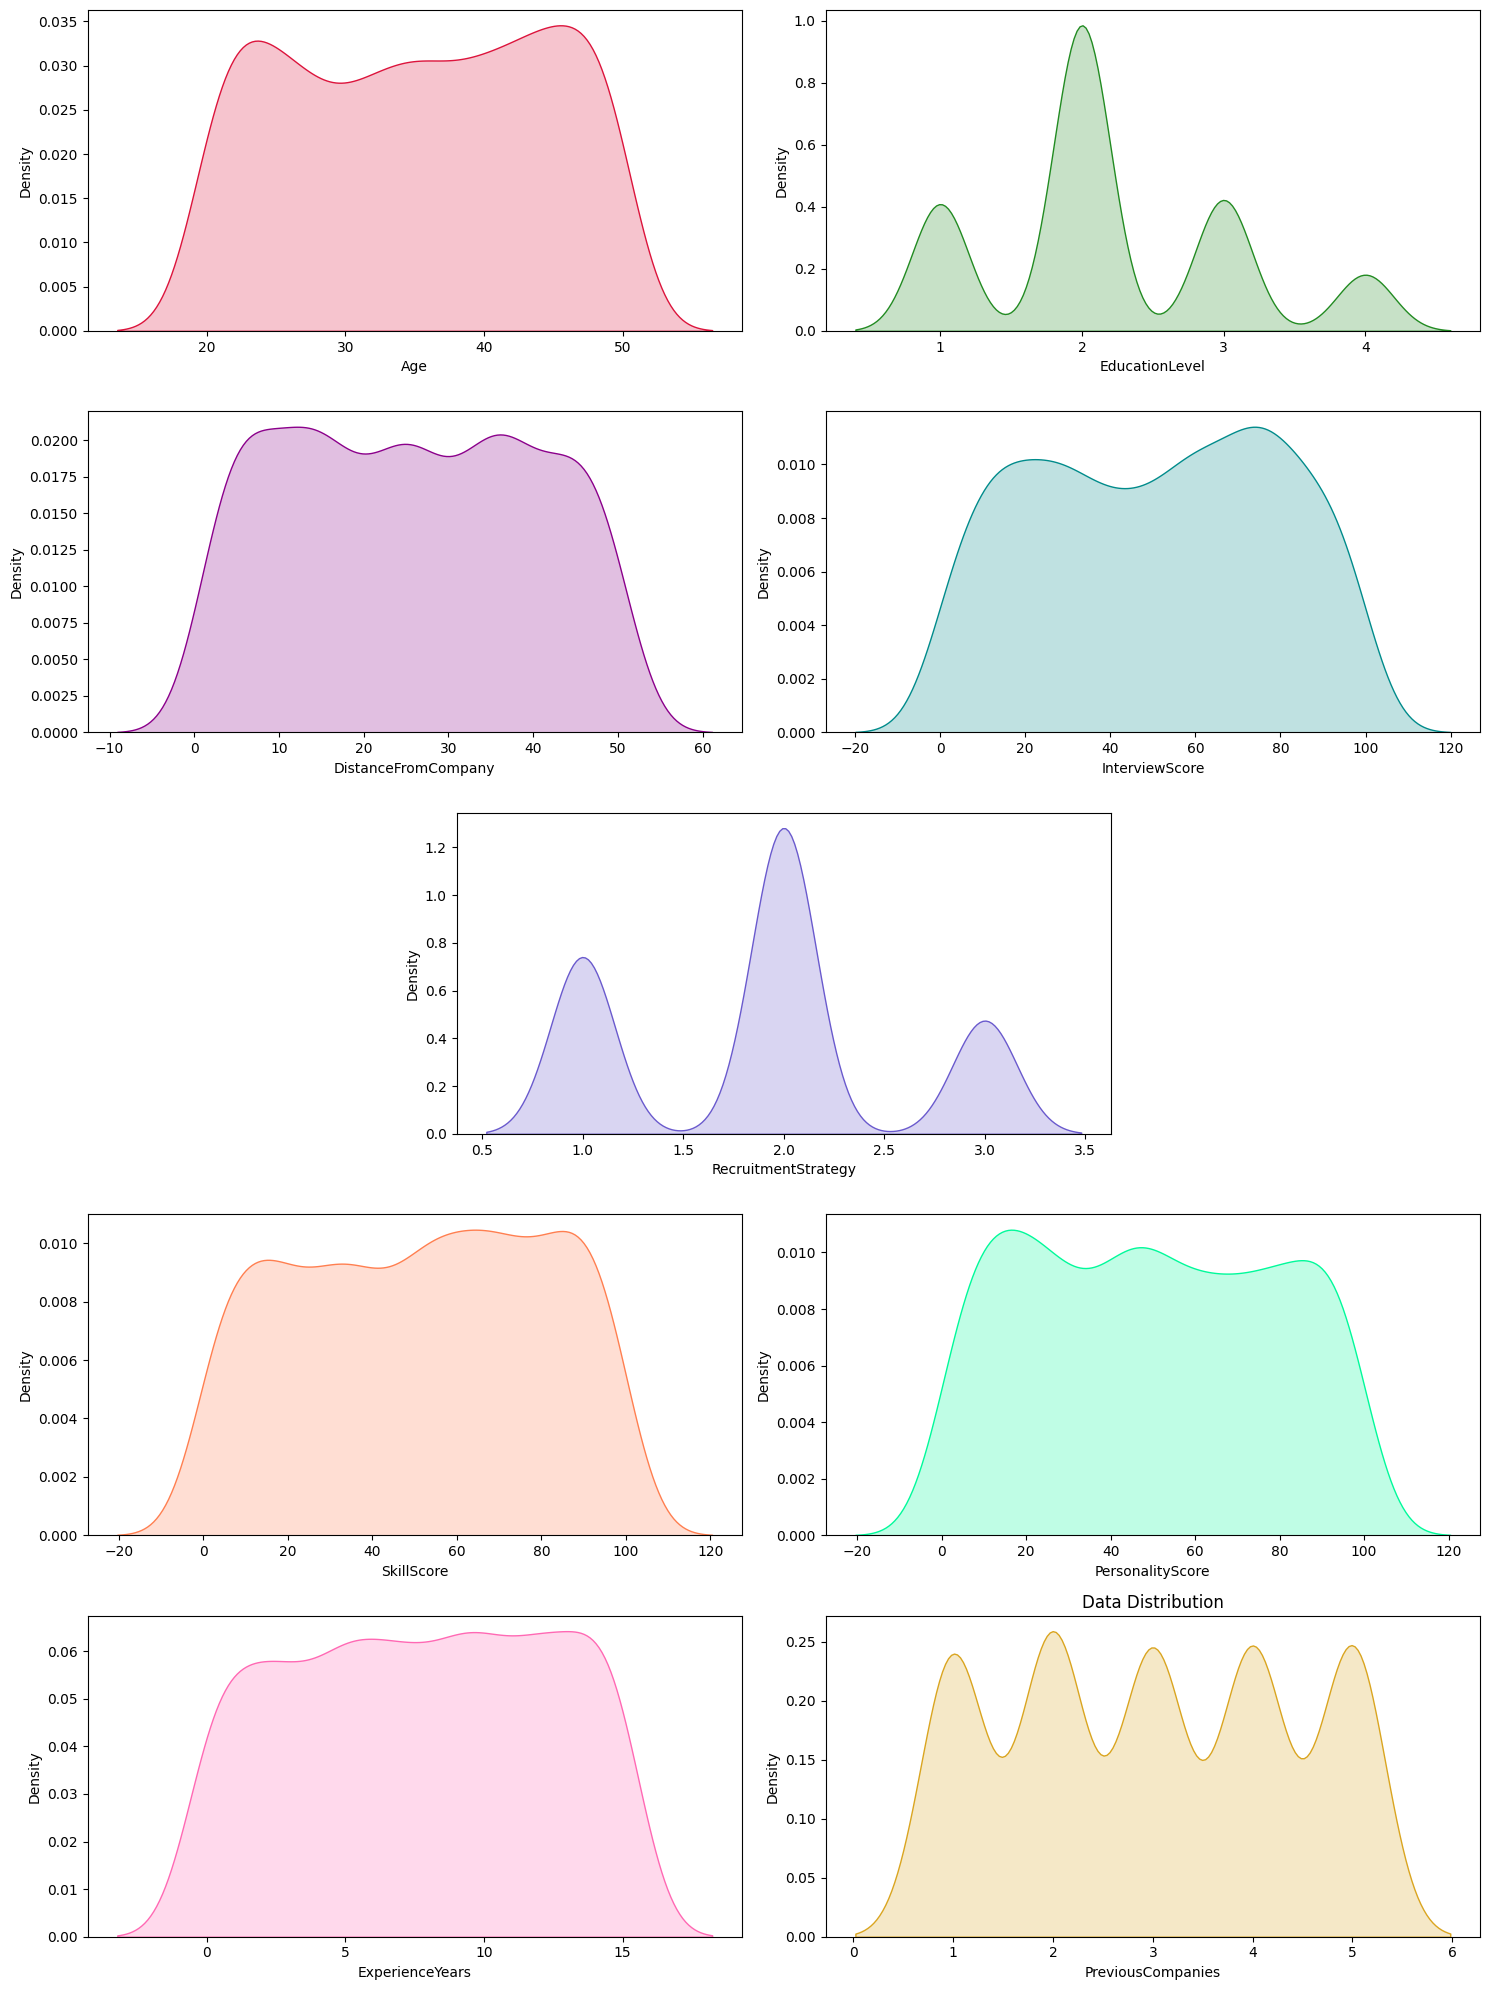

In [19]:
newdf5=data.drop(['HiringDecision','Gender'],axis=1)
axes=plt.subplot_mosaic("""AABB
                           EEFF
                           .II.
                           GGHH
                           CCDD""",figsize=(15,20))
alpha=['A','B','C','D','E','F','G','H','I']
count=0
color=['crimson','forestgreen','hotpink','goldenrod','darkmagenta','darkcyan','coral','mediumspringgreen','slateblue']
for i in newdf5.columns:
    sb.kdeplot(data=newdf5,x=data[i],ax=axes[1][alpha[count]],color=color[count],fill=True)
    count+=1
plt.title("Data Distribution")
plt.tight_layout()

* The age and interview distribution looks like bimodal distribution
* DistanceFromCompany,Skill Score,Personality Score,Experience Year , Interview Score looks like flattened normal distribution (low kurtosis)
* We can also see some density and distribution of data in different categorical variables

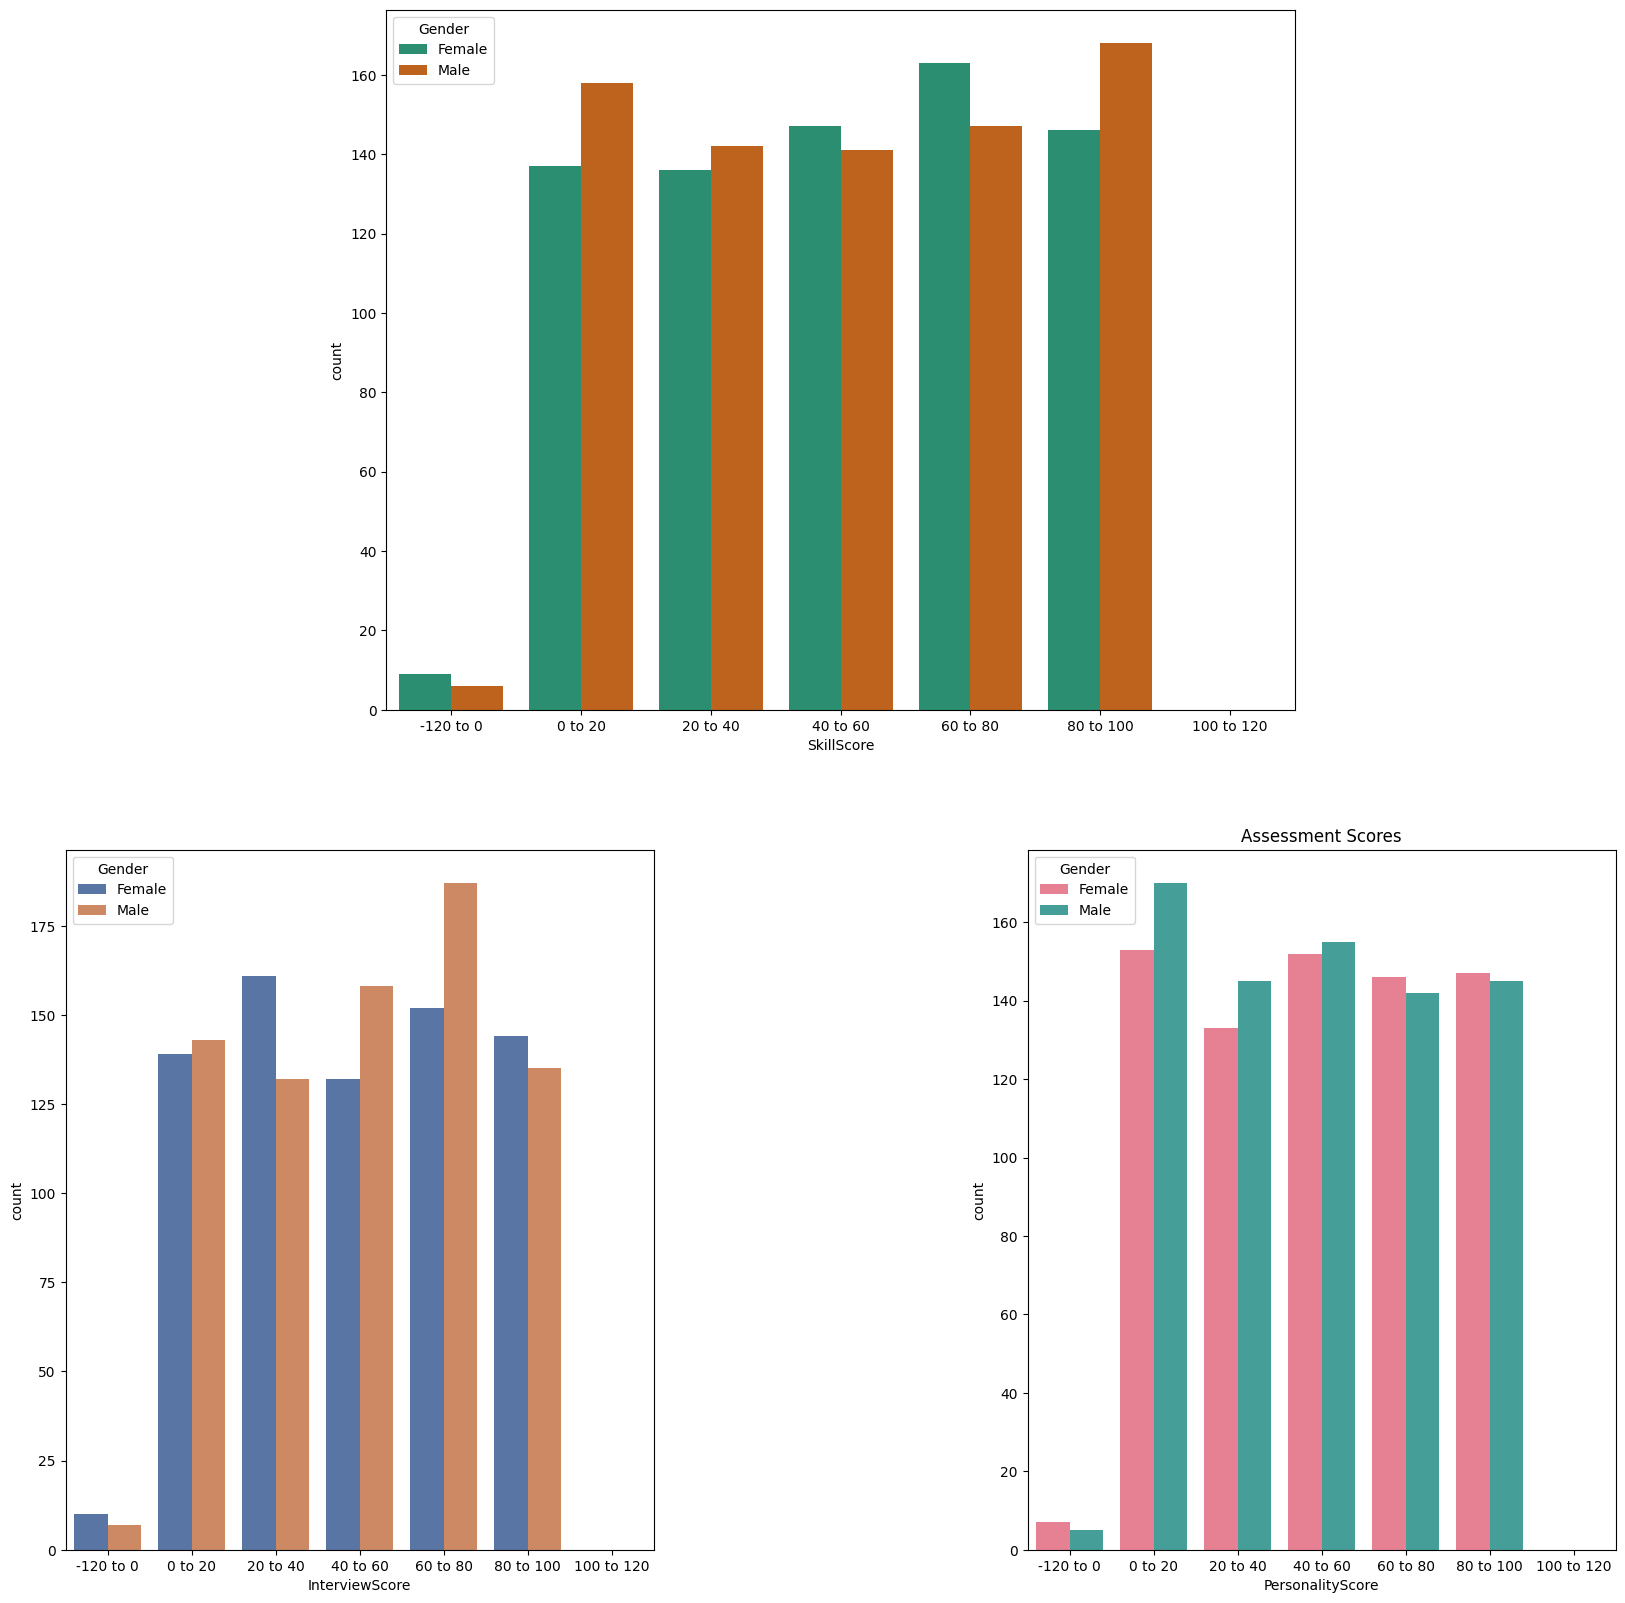

In [20]:
def score_cut(score):
    bins=[-120,0,20,40,60,80,100,120]
    labels=['-120 to 0','0 to 20','20 to 40','40 to 60','60 to 80','80 to 100','100 to 120']
    return pd.cut(score,bins=bins,labels=labels)
newdf5=data[['Gender']].replace({0:'Male',1:'Female'})
newdf5['InterviewScore']=score_cut(data['InterviewScore'])
newdf5['SkillScore']=score_cut(data['SkillScore'])
newdf5['PersonalityScore']=score_cut(data['PersonalityScore'])
fig,axes=plt.subplot_mosaic(""".CCC.
                               AA.BB
                               """,figsize=(20,20))
sb.countplot(data=newdf5,x='InterviewScore',hue='Gender',ax=axes['A'],palette='deep')
sb.countplot(data=newdf5,x='PersonalityScore',hue='Gender',ax=axes['B'],palette='husl')
sb.countplot(data=newdf5,x='SkillScore',hue='Gender',ax=axes['C'],palette='Dark2')
plt.title('Assessment Scores')
plt.show()

**In 80 - 100 segment**,
* Male Performance good in skill assessment
* Female Performance good in Interview and Personality assessment

**Negative segment (-120 to 0)**
* Male occurrence is higher in all three kind of assessments

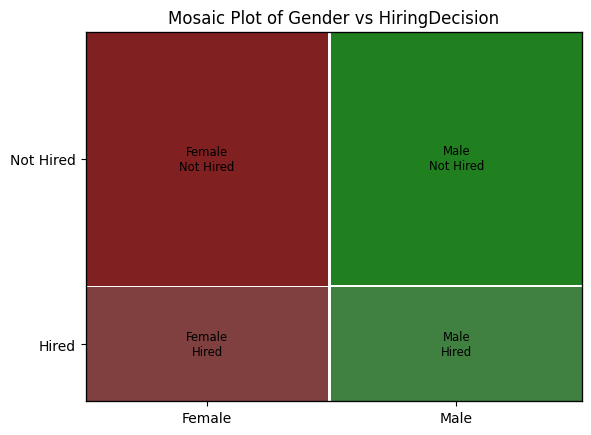

In [21]:
from statsmodels.graphics.mosaicplot import mosaic
newdf6=data[['HiringDecision','Gender']]
newdf6['Gender']=newdf6['Gender'].map({0:'Male',1:'Female'})
newdf6['HiringDecision']=newdf6['HiringDecision'].map({1:'Hired',0:'Not Hired'})
mosaic(newdf6, ['Gender', 'HiringDecision'])
plt.title("Mosaic Plot of Gender vs HiringDecision")
plt.show()


# Resampling

In [22]:
max_class=data.query("HiringDecision == 1")
min_class=data.query("HiringDecision == 0")
min_class=resample(min_class,replace=True,n_samples=len(max_class))

In [23]:
newdata2=pd.concat([max_class,min_class])
x=newdata2.drop('HiringDecision',axis=1)
y=newdata2['HiringDecision']

# Model Training

In [24]:
model1,model2,model3,model4,model5,model6,model7,model8,model9=LinearDiscriminantAnalysis(),KNeighborsClassifier(),LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),GradientBoostingClassifier(),BaggingClassifier(),GaussianNB(),xgb.XGBClassifier()
std=('std',StandardScaler(),['Age','DistanceFromCompany','InterviewScore','SkillScore','PersonalityScore'])
model_names=['LinearDiscriminantAnalysis','KNeighborsClassifier','LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','GradientBoostingClassifier','BaggingClassifier','GaussianNB','XGBClassifier']

In [25]:
col=ColumnTransformer([std],remainder='passthrough')
pipe1=Pipeline(steps=[('std',col),(model_names[0],model1)])
pipe2=Pipeline(steps=[('std',col),(model_names[1],model2)])
pipe3=Pipeline(steps=[('std',col),(model_names[2],model3)])
pipe4=Pipeline(steps=[('std',col),(model_names[3],model4)])
pipe5=Pipeline(steps=[('std',col),(model_names[4],model5)])
pipe6=Pipeline(steps=[('std',col),(model_names[5],model6)])
pipe7=Pipeline(steps=[('std',col),(model_names[6],model7)])
pipe8=Pipeline(steps=[('std',col),(model_names[7],model8)])
pipe9=Pipeline(steps=[('std',col),(model_names[8],model9)])
pipes=[pipe1,pipe2,pipe3,pipe4,pipe5,pipe6,pipe7,pipe8,pipe9]
x=data.drop('HiringDecision',axis=1)
y=data[['HiringDecision']]
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2)
for i in pipes:
    i.fit(xtrain,ytrain)
scores=[]
for i in pipes:
    scores.append(i.score(xtest,ytest))

In [26]:
pd.Series(data=np.round(np.array(scores),decimals=2),index=model_names)

LinearDiscriminantAnalysis    0.87
KNeighborsClassifier          0.81
LogisticRegression            0.87
DecisionTreeClassifier        0.86
RandomForestClassifier        0.91
GradientBoostingClassifier    0.95
BaggingClassifier             0.91
GaussianNB                    0.87
XGBClassifier                 0.94
dtype: float64

In [27]:
from tensorflow.keras.layers import Input,Dense,BatchNormalization
from tensorflow.keras.models import Model

In [28]:
i=Input(shape=(10,),name='Input_layer')
x=Dense(50,activation='relu',)(i)
x=BatchNormalization()(x)
x=Dense(1,activation='sigmoid',)(x)
model=Model(inputs=i,outputs=x)


In [29]:
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

In [30]:
def schedule(epochs):
    if epochs<200:
        return 0.05
    else:
        return 0.01
lr=LearningRateScheduler(schedule=schedule)

In [31]:
r=model.fit(xtrain,ytrain,validation_split=0.2,epochs=400,verbose=1,callbacks=[lr])

Epoch 1/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6456 - loss: 0.6777 - val_accuracy: 0.2958 - val_loss: 2.5471 - learning_rate: 0.0500
Epoch 2/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7208 - loss: 0.5415 - val_accuracy: 0.5625 - val_loss: 0.8555 - learning_rate: 0.0500
Epoch 3/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7871 - loss: 0.4833 - val_accuracy: 0.7792 - val_loss: 0.5207 - learning_rate: 0.0500
Epoch 4/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7965 - loss: 0.4354 - val_accuracy: 0.7000 - val_loss: 0.6235 - learning_rate: 0.0500
Epoch 5/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8038 - loss: 0.4515 - val_accuracy: 0.7667 - val_loss: 0.5618 - learning_rate: 0.0500
Epoch 6/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8200 - loss: 0.4210 - val_accuracy: 0.7583 - val_loss: 0.5336 - learning_rate: 0.0500
Epoch 7/400
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8026 - loss: 0.4295 - val_acc

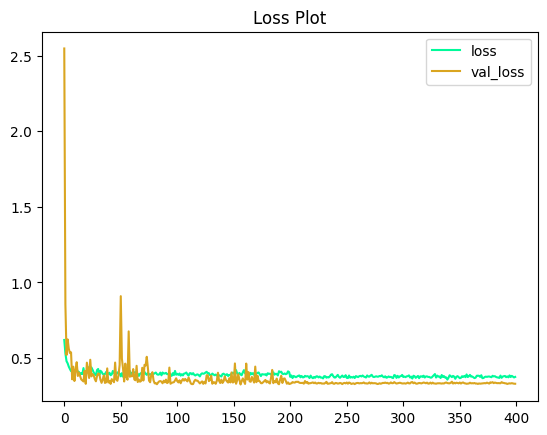

In [32]:
history=r.history
sb.lineplot(history['loss'],label='loss',color='mediumspringgreen')
sb.lineplot(history['val_loss'],label='val_loss',color='goldenrod')
plt.title('Loss Plot')
plt.legend()
